In [1]:
import tensorflow
import keras
import matplotlib 
import pydot
import graphviz
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from kerastuner import HyperModel
from tensorflow import keras
import tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow.compat.v1 as tf 
import splitfolders
from sklearn.model_selection import KFold

C:\Users\anato\AppData\Local\Temp/ipykernel_26152/585483721.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [2]:
data_folder = 'C:/Users/anato/Desktop/Università/ML/archive/df'

In [ ]:
# to skip once you have the output folder ready 
splitfolders.ratio('/Users/anato/Desktop/Università/ML/archive/df', output = "output",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [3]:
train = 'output\train'
val = 'output\val'
test = 'output\test'

In [4]:
root_path = 'output'
categories = ['train', 'val','test']
classes = ['muffin', 'chihuahua']

In [5]:
def removal_corrupted_files(category):
    num_skipped = 0
    for class_name in classes:
        folder = os.path.join(root_path, category, class_name)
        if not os.path.exists(folder):
            print("Directory does not exist, skipping:", folder)
            continue
            
        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            try:
                with open(fpath, "rb") as fobj:
                    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
                    
            except IOError as e:
                print("Error opening file:", e)
                continue
                
            if not is_jfif or os.stat(fpath).st_size == 0:
                num_skipped += 1
                # Delete corrupted or empty image
                print(f"Removing corrupted or empty image: {fpath}")
                os.remove(fpath)

    print(f"Deleted {num_skipped} images from {category} category.")
    return os.path.join(root_path, category)  # Return the path to the cleaned category


In [6]:
train_clean = removal_corrupted_files('train')
val_clean = removal_corrupted_files('val')
test_clean = removal_corrupted_files('test')

Deleted 0 images from train category.
Deleted 0 images from val category.
Deleted 0 images from test category.


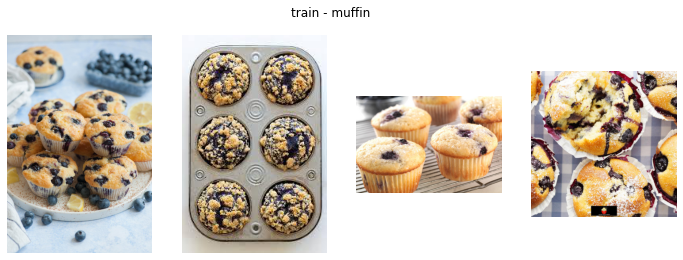

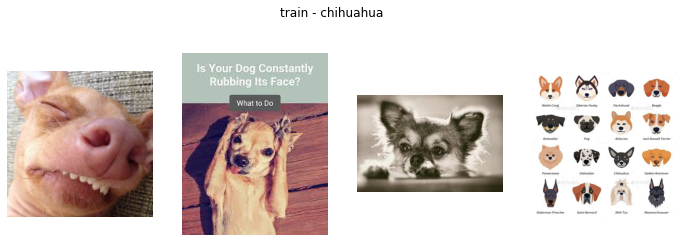

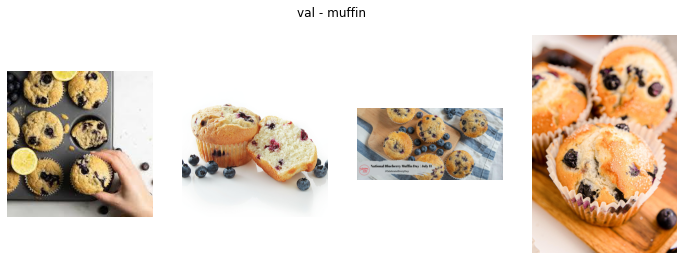

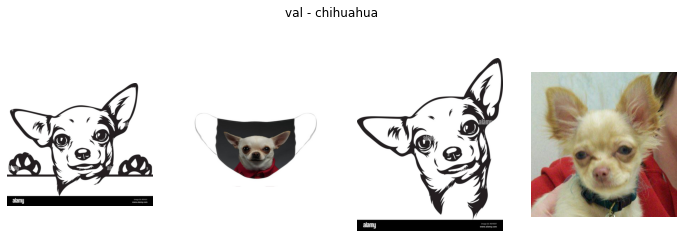

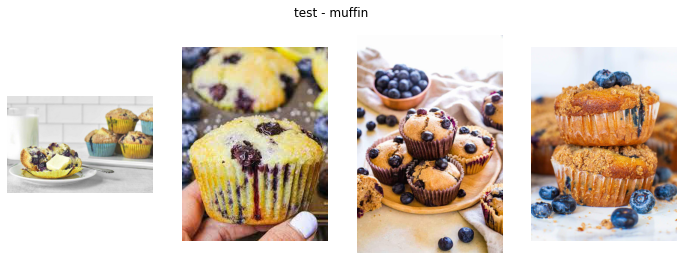

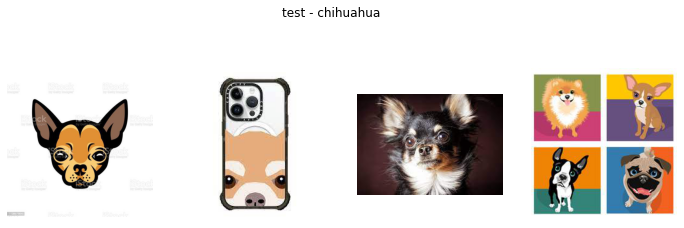

In [7]:
num_images_to_display = 4

# Function to load images from the specified directory
def load_images_from_folder(folder, num_images):
    images = []
    for filename in os.listdir(folder):
        if len(images) == num_images:
            break
        img_path = os.path.join(folder, filename)
        try:
            with Image.open(img_path) as img:
                images.append(img.copy())
        except (IOError, FileNotFoundError):
            continue
    return images

# Function to display images
def display_images(images, title):
    plt.figure(figsize=(12, 4))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Iterate over categories and classes and display images
for category in categories:
    for class_name in classes:
        folder = os.path.join(root_path, category, class_name)
        images = load_images_from_folder(folder, num_images_to_display)
        display_images(images, f"{category} - {class_name}")

In [8]:
# Function for preprocessing the images 
def preprocessing_step(folder, IMG_SIZE):
    categories = ['muffin', 'chihuahua']
    data = []

    for category in categories:
        path = os.path.join(folder, category)
        if not os.path.exists(path):
            print(f"Category path does not exist: {path}")
            continue
            
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file) # get the full image path
            label = categories.index(category)  # get the label (index in categories list)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Convert image to RGB
                    img = img.resize((IMG_SIZE, IMG_SIZE))  # Resize the image
                    img_array = np.array(img)  # Convert to NumPy array
                    data.append([img_array, label])  # Append image data and label to the data list
            except Exception as e:
                print(f"Could not process image {img_path}: {e}")  # Output an error message if the image cannot be processed

    return data

In [9]:
train = preprocessing_step(train_clean, 90)
test = preprocessing_step(test_clean, 90)
val = preprocessing_step(val_clean, 90)

In [10]:
# dataset
n_muffin = len(os.listdir('/Users/anato/Desktop/Università/ML/archive/df/muffin'))
n_chihuahua = len(os.listdir('/Users/anato/Desktop/Università/ML/archive/df/chihuahua'))
total = n_muffin + n_chihuahua

In [11]:
print("Muffin photos :" +str(n_muffin))
print("Chihuahua photos:" +str(n_chihuahua))

# checking for class imbalance
print('Examples:\n    Total: {}\n    Chihuahua: {} ({:.2f}% of total)\n'.format(
    total, n_chihuahua, (100 * n_chihuahua / (n_muffin + n_chihuahua))))

Muffin photos :2718
Chihuahua photos:3199
Examples:
    Total: 5917
    Chihuahua: 3199 (54.06% of total)



In [12]:
X = []  # Temporary list to hold features
y = []  # Temporary list to hold labels

for features, label in train:
    X.append(features)
    y.append(label)

# Convert to numpy arrays

X_train = np.array(X)
y_train = np.array(y)
# Rescaling
X_train = X_train / 255

In [13]:
X = []  # Temporary list to hold features
y = []  # Temporary list to hold labels

for features, label in test:
    X.append(features)
    y.append(label)

# Convert to numpy arrays
X_test = np.array(X)
y_test = np.array(y)
# Rescaling
X_test = X_test / 255

In [101]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4733, 90, 90, 3)
(4733,)
(594, 90, 90, 3)
(594,)


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

## Model 1: Baseline model + variations
The first 3 models are baseline models, trained on the original dataset. 
- Model 1 is made up of only 2 convolutional layers, with 32 and 64 filters, and one dense layer with 32 nodes. To each layer I've added a dropout layer for regularization purposes.
- Model 2 adds one layer to the past one, thus deepening the architecture.
- Model 3 further increases the depth of the architecture. + add results 

The models are result of a selection process based on validation loss and accuracy.

In [16]:
np.random.seed(625)

In [17]:
from keras.callbacks import EarlyStopping
# Start by adding early stopping to all models, so that the epochs stop before the model overfits
def get_callbacks(patience):
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                verbose=1,
                restore_best_weights=True
            )
        ]

In [18]:
# Model 1: 1 CovNet followed by a dense layer
model1 = Sequential()

#First convolutional layer with 32 filters
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

#Flatten layer
model1.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

#Fully Connected Layers
model1.add(Dense(32, activation='relu')) 
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid')) 

In [19]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history1 = model1.fit(X_train, y_train, epochs=50, validation_split = 0.2, callbacks=get_callbacks(9))  

Epoch 1/50
119/119 [==============================] - 13s 103ms/step - loss: 0.7254 - accuracy: 0.5618 - val_loss: 0.7667 - val_accuracy: 0.0000e+00
Epoch 2/50
119/119 [==============================] - 12s 98ms/step - loss: 0.6291 - accuracy: 0.5954 - val_loss: 0.7153 - val_accuracy: 0.5259
Epoch 3/50
119/119 [==============================] - 12s 98ms/step - loss: 0.5481 - accuracy: 0.7018 - val_loss: 0.5879 - val_accuracy: 0.6695
Epoch 4/50
119/119 [==============================] - 11s 94ms/step - loss: 0.5218 - accuracy: 0.7079 - val_loss: 0.7064 - val_accuracy: 0.5290
Epoch 5/50
119/119 [==============================] - 11s 94ms/step - loss: 0.5110 - accuracy: 0.7079 - val_loss: 0.4659 - val_accuracy: 0.7677
Epoch 6/50
119/119 [==============================] - 11s 96ms/step - loss: 0.4847 - accuracy: 0.7213 - val_loss: 0.4481 - val_accuracy: 0.7867
Epoch 7/50
119/119 [==============================] - 12s 98ms/step - loss: 0.4620 - accuracy: 0.7591 - val_loss: 0.8491 - val_accu

Text(0.5, 1.0, 'Model 1: Training vs Validation Accuracy')

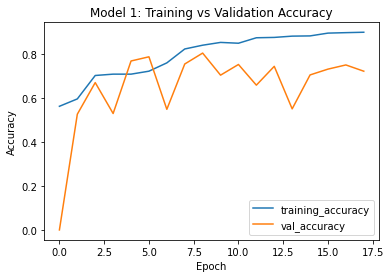

In [21]:
plt.plot(history1.history['accuracy'], label='training_accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Model 1: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 1: Training vs Validation Loss')

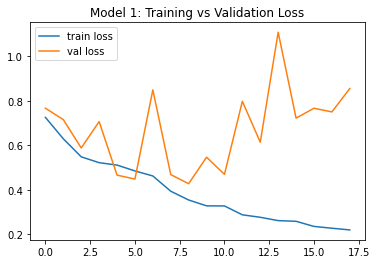

In [22]:
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 1: Training vs Validation Loss")

In [75]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print("Test Accuracy: "+str(test_accuracy))
print("Test Loss: "+str(test_loss))

19/19 [==============================] - 0s 21ms/step - loss: 0.3802 - accuracy: 0.8418
Test Accuracy: 0.8417508602142334
Test Loss: 0.38024473190307617


In [30]:
# Model 1.2 : 2 CovNets followed by a dense layer
model1_2 = Sequential()

#First convolutional layer with 32 filters
model1_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
model1_2.add(MaxPooling2D((2, 2)))
model1_2.add(Dropout(0.5))

#Second convolutional layer with 64 filters
model1_2.add(Conv2D(64, (3, 3), activation='relu')) 
model1_2.add(MaxPooling2D((2, 2)))
model1_2.add(Dropout(0.5))

#Flatten layer
model1_2.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

#Fully Connected Layers
model1_2.add(Dense(32, activation='relu'))
model1_2.add(Dropout(0.5))

model1_2.add(Dense(1, activation='sigmoid'))

In [31]:
model1_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
history1_2 = model1_2.fit(X_train, y_train, epochs=50, validation_split = 0.2, callbacks=get_callbacks(9))  

Epoch 1/50
119/119 [==============================] - 42s 342ms/step - loss: 0.6746 - accuracy: 0.5716 - val_loss: 0.6898 - val_accuracy: 0.7339
Epoch 2/50
119/119 [==============================] - 39s 329ms/step - loss: 0.5198 - accuracy: 0.7382 - val_loss: 0.7315 - val_accuracy: 0.6737
Epoch 3/50
119/119 [==============================] - 39s 330ms/step - loss: 0.4431 - accuracy: 0.8201 - val_loss: 0.5977 - val_accuracy: 0.8120
Epoch 4/50
119/119 [==============================] - 39s 331ms/step - loss: 0.4091 - accuracy: 0.8420 - val_loss: 0.9331 - val_accuracy: 0.5628
Epoch 5/50
119/119 [==============================] - 39s 325ms/step - loss: 0.4078 - accuracy: 0.8450 - val_loss: 0.5005 - val_accuracy: 0.8279
Epoch 6/50
119/119 [==============================] - 39s 325ms/step - loss: 0.3778 - accuracy: 0.8566 - val_loss: 0.4730 - val_accuracy: 0.8501
Epoch 7/50
119/119 [==============================] - 38s 322ms/step - loss: 0.3619 - accuracy: 0.8513 - val_loss: 0.4538 - val_ac

Text(0.5, 1.0, 'Model 1.2: Training vs Validation Accuracy')

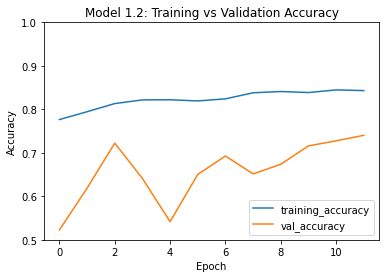

In [34]:
plt.plot(history1_2.history['accuracy'], label='training_accuracy')
plt.plot(history1_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 1.2: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 1.2: Training vs Validation Loss')

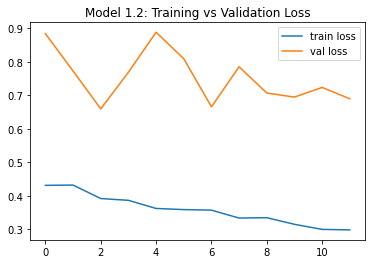

In [35]:
plt.plot(history1_2.history['loss'], label='train loss')
plt.plot(history1_2.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 1.2: Training vs Validation Loss")

In [76]:
test_loss, test_accuracy = model1_2.evaluate(X_test, y_test)
print("Test Accuracy: "+str(test_accuracy))
print("Test Loss: "+str(test_loss))

19/19 [==============================] - 1s 33ms/step - loss: 0.4545 - accuracy: 0.8165
Test Accuracy: 0.816498339176178
Test Loss: 0.4544534385204315


In [37]:
# Model 1.3 : Add a dropout layer to each convolutional layer and to the dense layer
model1_3 = Sequential()

# First convolutional layer with 32 filters
model1_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
model1_3.add(MaxPooling2D((2, 2)))
model1_3.add(Dropout(0.5))

# Second convolutional layer with 64 filters
model1_3.add(Conv2D(64, (3, 3), activation='relu'))
model1_3.add(MaxPooling2D((2, 2)))
model1_3.add(Dropout(0.5))

# Add a flatten layer 
model1_3.add(Flatten())

# Dense layer and drop-out layer for regularization
model1_3.add(Dense(32, activation='relu'))
model1_3.add(Dropout(0.5))
model1_3.add(Dense(1, activation='sigmoid'))

In [38]:
model1_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
history1_3 = model1_3.fit(X_train, y_train, epochs=50, validation_split = 0.2, callbacks=get_callbacks(9))

Epoch 1/50
119/119 [==============================] - 23s 191ms/step - loss: 0.4620 - accuracy: 0.7731 - val_loss: 0.7913 - val_accuracy: 0.5977
Epoch 2/50
119/119 [==============================] - 20s 167ms/step - loss: 0.4206 - accuracy: 0.7985 - val_loss: 0.8810 - val_accuracy: 0.5470
Epoch 3/50
119/119 [==============================] - 20s 167ms/step - loss: 0.3873 - accuracy: 0.8122 - val_loss: 0.7716 - val_accuracy: 0.6505
Epoch 4/50
119/119 [==============================] - 19s 163ms/step - loss: 0.3954 - accuracy: 0.8207 - val_loss: 0.7494 - val_accuracy: 0.6822
Epoch 5/50
119/119 [==============================] - 20s 165ms/step - loss: 0.3618 - accuracy: 0.8312 - val_loss: 0.5535 - val_accuracy: 0.7983
Epoch 6/50
119/119 [==============================] - 20s 172ms/step - loss: 0.3680 - accuracy: 0.8262 - val_loss: 0.9294 - val_accuracy: 0.4393
Epoch 7/50
119/119 [==============================] - 19s 162ms/step - loss: 0.3468 - accuracy: 0.8376 - val_loss: 0.6636 - val_ac

Text(0.5, 1.0, 'Model 1.3: Training vs Validation Accuracy')

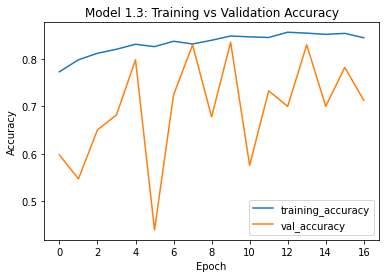

In [42]:
plt.plot(history1_3.history['accuracy'], label='training_accuracy')
plt.plot(history1_3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 1.3: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 1.3: Training vs Validation Loss')

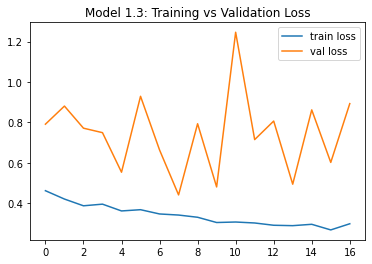

In [43]:
plt.plot(history1_3.history['loss'], label='train loss')
plt.plot(history1_3.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 1.3: Training vs Validation Loss")

In [77]:
test_loss, test_accuracy = model1_3.evaluate(X_test, y_test)
print("Test Accuracy: "+str(test_accuracy))
print("Test Loss: "+str(test_loss))

19/19 [==============================] - 1s 30ms/step - loss: 0.3802 - accuracy: 0.8569
Test Accuracy: 0.8569023609161377
Test Loss: 0.380216121673584


## Models 4 and 5: increasing the depth of the models and adding data augmentation layer
The 2 models are the best performing models I've reached by experimenting with the different layers and parameters. To both, I've added a data augmentation layer that created new images from the original dataset by randomly flipping some images, rotating them or zooming on certain parts of the images.

- Model 4 adds to the past models a fourth layer with 128 filters;
- In model 4.1 I remove the dropout layers and add a Batch Normalization layer to each convolutional layer to compare results.
- Model 5 I add one final, fifth layer, with 256 filters. However, the additional layer does not improve the performance of the 4th model much.

In [45]:
train_datagen = ImageDataGenerator(
        rescale=1./255)        

test_datagen = ImageDataGenerator(rescale=1./255)

In [46]:
# The models are trained on a larger version of the previous dataset, but has never seen the validation data
train_generator = train_datagen.flow_from_directory(
        'output/train',
        target_size=(90, 90),
        batch_size=32,
        class_mode='binary')

val_generator = test_datagen.flow_from_directory(
        'output/val', 
        target_size=(90, 90),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'output/test', 
        target_size=(90, 90),
        batch_size=32,
        class_mode='binary')

Found 4733 images belonging to 2 classes.
Found 589 images belonging to 2 classes.
Found 594 images belonging to 2 classes.


In [47]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [147]:
def model4():
    # Model 4 : Add a third layer and a dropout layer to each convolutional layer, + add a data augmentation layer
    model4 = Sequential()

    # Add a data augmentation layer 
    model4.add(data_augmentation)

    # First convolutional layer with 32 filters
    model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
    model4.add(MaxPooling2D((2, 2)))
    model4.add(Dropout(0.5))

    # Second convolutional layer with 64 filters
    model4.add(Conv2D(64, (3, 3), activation='relu'))
    model4.add(MaxPooling2D((2, 2)))
    model4.add(Dropout(0.5))

    #Third convolutional layer with 128 filters
    model4.add(Conv2D(128, (3, 3), activation='relu'))
    model4.add(MaxPooling2D((2, 2)))
    model4.add(Dropout(0.5))

    # Add a filter layer 
    model4.add(Flatten())

    # Dense layer and drop-out layer for regularization
    model4.add(Dense(32, activation='relu'))
    model4.add(Dropout(0.5))
    model4.add(Dense(1, activation='sigmoid'))
    
    model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model4

In [148]:
model4 = model4()
history4 = model4.fit(train_generator, validation_data = val_generator, epochs=50, callbacks=get_callbacks(8))

Epoch 1/50
148/148 [==============================] - 83s 544ms/step - loss: 0.6935 - accuracy: 0.5567 - val_loss: 0.6470 - val_accuracy: 0.7657
Epoch 2/50
148/148 [==============================] - 71s 480ms/step - loss: 0.5943 - accuracy: 0.6860 - val_loss: 0.5098 - val_accuracy: 0.8217
Epoch 3/50
148/148 [==============================] - 75s 511ms/step - loss: 0.5536 - accuracy: 0.7376 - val_loss: 0.5805 - val_accuracy: 0.7776
Epoch 4/50
148/148 [==============================] - 79s 531ms/step - loss: 0.5404 - accuracy: 0.7361 - val_loss: 0.4905 - val_accuracy: 0.7810
Epoch 5/50
148/148 [==============================] - 75s 505ms/step - loss: 0.5079 - accuracy: 0.7642 - val_loss: 0.4595 - val_accuracy: 0.8183
Epoch 6/50
148/148 [==============================] - 75s 504ms/step - loss: 0.4813 - accuracy: 0.7828 - val_loss: 0.5002 - val_accuracy: 0.7453
Epoch 7/50
148/148 [==============================] - 75s 506ms/step - loss: 0.4488 - accuracy: 0.7972 - val_loss: 0.5016 - val_ac

Text(0.5, 1.0, 'Model 4: Training vs Validation Accuracy')

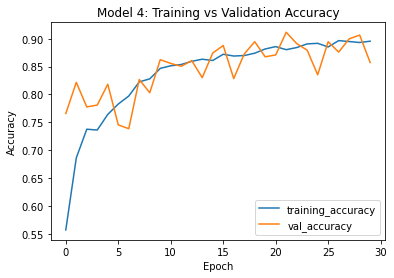

In [149]:
plt.plot(history4.history['accuracy'], label='training_accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 4: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 4: Training vs Validation Loss')

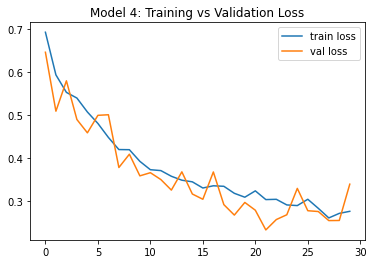

In [150]:
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 4: Training vs Validation Loss")

In [154]:
test_loss, test_accuracy = model4.evaluate(test_generator)
print("Test Accuracy: "+str(test_accuracy))
print("Test Loss: "+str(test_loss))

19/19 [==============================] - 7s 358ms/step - loss: 0.2767 - accuracy: 0.8704
Test Accuracy: 0.8703703880310059
Test Loss: 0.27666476368904114


In [54]:
from keras.layers import BatchNormalization
def model4_1()
    model4_1 = Sequential()

    # Adding a data augmentation layer
    model4_1.add(data_augmentation)
    # First convolutional layer with 32 filters
    model4_1.add(Conv2D(32, (3, 3), input_shape=(90, 90, 3)))
    model4_1.add(BatchNormalization())
    model4_1.add(Activation('relu'))
    model4_1.add(MaxPooling2D((2, 2)))
    #model1_4_1.add(Dropout(0.5))

    # Second convolutional layer with 64 filters
    model4_1.add(Conv2D(64, (3, 3)))
    model4_1.add(BatchNormalization())
    model4_1.add(Activation('relu'))
    model4_1.add(MaxPooling2D((2, 2)))
    #model1_4_1.add(Dropout(0.5))

    # Flatten the output of the convolutional layers
    model4_1.add(Flatten())

    # Dense layer with 32 neurons
    model4_1.add(Dense(32))
    model4_1.add(BatchNormalization())
    model4_1.add(Activation('relu'))

    # Output layer with single neuron and sigmoid activation for binary classification
    model4_1.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model4_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model4_1

In [55]:
model4_1 = model4_1()
# Fit model (use the previously defined early_stopping and tensorboard callbacks)
history4_1 = model4_1.fit(train_generator, validation_data = val_generator, epochs=60, callbacks=get_callbacks(7))

Epoch 1/60
148/148 [==============================] - 69s 453ms/step - loss: 0.4326 - accuracy: 0.8128 - val_loss: 1.9059 - val_accuracy: 0.5399
Epoch 2/60
148/148 [==============================] - 67s 452ms/step - loss: 0.3165 - accuracy: 0.8652 - val_loss: 1.5023 - val_accuracy: 0.5450
Epoch 3/60
148/148 [==============================] - 66s 448ms/step - loss: 0.2797 - accuracy: 0.8889 - val_loss: 0.5976 - val_accuracy: 0.7470
Epoch 4/60
148/148 [==============================] - 66s 448ms/step - loss: 0.2732 - accuracy: 0.8939 - val_loss: 0.6618 - val_accuracy: 0.6520
Epoch 5/60
148/148 [==============================] - 68s 456ms/step - loss: 0.2495 - accuracy: 0.8967 - val_loss: 0.4671 - val_accuracy: 0.7827
Epoch 6/60
148/148 [==============================] - 67s 453ms/step - loss: 0.2407 - accuracy: 0.9026 - val_loss: 0.8402 - val_accuracy: 0.5925
Epoch 7/60
148/148 [==============================] - 66s 448ms/step - loss: 0.2303 - accuracy: 0.9053 - val_loss: 0.4470 - val_ac

Text(0.5, 1.0, 'Model 4.1: Training vs Validation Accuracy')

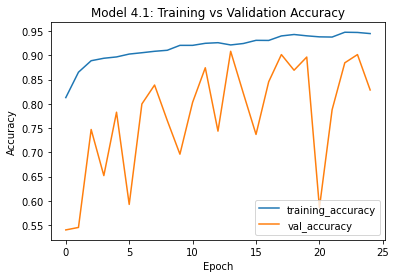

In [56]:
plt.plot(history4_1.history['accuracy'], label='training_accuracy')
plt.plot(history4_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 4.1: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 4.1: Training vs Validation Loss')

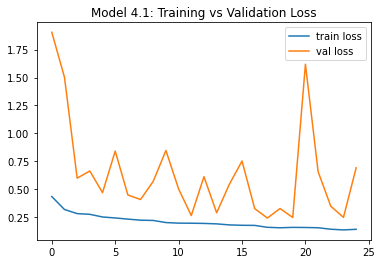

In [57]:
plt.plot(history4_1.history['loss'], label='train loss')
plt.plot(history4_1.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 4.1: Training vs Validation Loss")

In [85]:
test_loss, test_accuracy = model4_1.evaluate(test_generator)
print("Test Accuracy: "+str(test_accuracy))
print("Test Loss: "+str(test_loss))

19/19 [==============================] - 6s 288ms/step - loss: 0.2664 - accuracy: 0.8939
Test Accuracy: 0.8939393758773804
Test Loss: 0.266416996717453


In [108]:
# Model 5 : Add a fourth layer and a dropout layer to each convolutional layer
def model5():
    
    model5 = Sequential()

    # Adding a data augmentation layer
    model5.add(data_augmentation)

    # First convolutional layer with 32 filters
    model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
    model5.add(MaxPooling2D((2, 2)))
    model5.add(Dropout(0.5))

    # Second convolutional layer with 64 filters
    model5.add(Conv2D(64, (3, 3), activation='relu'))
    model5.add(MaxPooling2D((2, 2)))
    model5.add(Dropout(0.5))

    #Third convolutional layer with 128 filters
    model5.add(Conv2D(128, (3, 3), activation='relu'))
    model5.add(MaxPooling2D((2, 2)))
    model5.add(Dropout(0.5))

    # Fourth convolutional layer with 256 filters
    model5.add(Conv2D(256, (3, 3), activation='relu'))
    model5.add(MaxPooling2D((2, 2)))
    model5.add(Dropout(0.5))

    # Add a filter layer 
    model5.add(Flatten())

    # Dense layer and drop-out layer for regularization
    model5.add(Dense(32, activation='relu'))
    model5.add(Dropout(0.5))
    model5.add(Dense(1, activation='sigmoid'))
    
    model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model5

In [59]:
model5 = model5()
history5 = model5.fit(train_generator, validation_data = val_generator, epochs=60, callbacks=get_callbacks(9))

Epoch 1/60
148/148 [==============================] - 70s 467ms/step - loss: 0.6844 - accuracy: 0.5417 - val_loss: 0.6284 - val_accuracy: 0.6435
Epoch 2/60
148/148 [==============================] - 68s 460ms/step - loss: 0.5972 - accuracy: 0.7078 - val_loss: 0.6150 - val_accuracy: 0.6282
Epoch 3/60
148/148 [==============================] - 68s 458ms/step - loss: 0.5396 - accuracy: 0.7503 - val_loss: 0.5686 - val_accuracy: 0.6825
Epoch 4/60
148/148 [==============================] - 69s 464ms/step - loss: 0.4963 - accuracy: 0.7919 - val_loss: 0.4336 - val_accuracy: 0.8591
Epoch 5/60
148/148 [==============================] - 68s 459ms/step - loss: 0.4622 - accuracy: 0.8065 - val_loss: 0.4511 - val_accuracy: 0.8014
Epoch 6/60
148/148 [==============================] - 68s 458ms/step - loss: 0.4197 - accuracy: 0.8251 - val_loss: 0.4601 - val_accuracy: 0.7691
Epoch 7/60
148/148 [==============================] - 68s 459ms/step - loss: 0.3920 - accuracy: 0.8460 - val_loss: 0.4177 - val_ac

Text(0.5, 1.0, 'Model 5: Training vs Validation Accuracy')

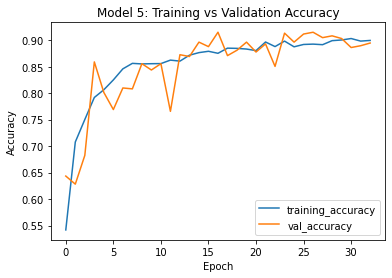

In [60]:
plt.plot(history5.history['accuracy'], label='training_accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
 #plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 5: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 5: Training vs Validation Loss')

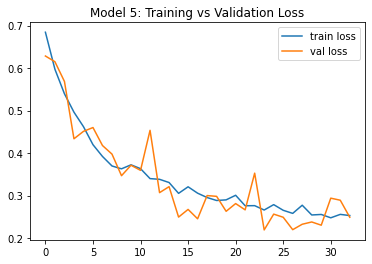

In [61]:
plt.plot(history5.history['loss'], label='train loss')
plt.plot(history5.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 5: Training vs Validation Loss")

In [86]:
test_loss, test_accuracy = model5.evaluate(test_generator)
print("Test Accuracy: "+str(test_accuracy))
print("Test Loss: "+str(test_loss))

19/19 [==============================] - 5s 276ms/step - loss: 0.2626 - accuracy: 0.8754
Test Accuracy: 0.875420868396759
Test Loss: 0.26262590289115906


## Hypermodel: model generated by tuning the hyperparameters with Bayesian Optimization

In [63]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = Sequential()
        
        # First convolutional layer with hp.Int for optimizing the number of filters
        model.add(Conv2D(hp.Int('filters_1', min_value=16, max_value=64, step=16),
                         kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.1)))

        # Second convolutional layer with hp.Int for optimizing the number of filters
        model.add(Conv2D(hp.Int('filters_2', min_value=32, max_value=128, step=32), 
                         kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.1)))

        # Third convolutional layer with hp.Int for optimizing the number of filters
        model.add(Conv2D(hp.Int('filters_3', min_value=64, max_value=256, step=64),
                         kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.3, max_value=0.7, step=0.1)))

        # Flatten layer to convert the 2D outputs to 1D
        model.add(Flatten())

        # Dense layer with hp.Int for optimizing the number of units
        model.add(Dense(hp.Int('units_1', min_value=16, max_value=128, step=16), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.3, max_value=0.7, step=0.1)))

        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        return model

In [64]:
from kerastuner.tuners import BayesianOptimization

tuner = BayesianOptimization(
    hypermodel=MyHyperModel(input_shape=(90, 90, 3)),
    objective='val_loss',   
    max_trials=20,           
    num_initial_points=5,      
    directory='my_dir',
    project_name='muffin vs chihuahua'
)

In [65]:
tuner.search(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=get_callbacks(5)
)

Trial 20 Complete [00h 55m 13s]
val_loss: 0.16801179945468903

Best val_loss So Far: 0.16801179945468903
Total elapsed time: 14h 52m 41s


In [66]:
best_hps = tuner.get_best_hyperparameters(num_trials=20)[0]

In [67]:
best_hps.values

{'filters_1': 64,
 'dropout_1': 0.4,
 'filters_2': 32,
 'dropout_2': 0.5,
 'filters_3': 128,
 'dropout_3': 0.6000000000000001,
 'units_1': 64,
 'dropout_4': 0.3,
 'learning_rate': 0.0003368139984780008}

In [69]:
# Build the best model using the hyperparameters obtained
best_model = tuner.hypermodel.build(best_hps)

# Train the model on the training data and compare it with the validation set
history_bm = best_model.fit(train_generator, validation_data = val_generator, epochs=60, callbacks=get_callbacks(6))

Epoch 1/60
148/148 [==============================] - 73s 487ms/step - loss: 0.6034 - accuracy: 0.6666 - val_loss: 0.5485 - val_accuracy: 0.7334
Epoch 2/60
148/148 [==============================] - 71s 478ms/step - loss: 0.4769 - accuracy: 0.7809 - val_loss: 0.4855 - val_accuracy: 0.7946
Epoch 3/60
148/148 [==============================] - 69s 467ms/step - loss: 0.4157 - accuracy: 0.8200 - val_loss: 0.5208 - val_accuracy: 0.7419
Epoch 4/60
148/148 [==============================] - 69s 464ms/step - loss: 0.3857 - accuracy: 0.8384 - val_loss: 0.4414 - val_accuracy: 0.8353
Epoch 5/60
148/148 [==============================] - 70s 476ms/step - loss: 0.3482 - accuracy: 0.8538 - val_loss: 0.3408 - val_accuracy: 0.8727
Epoch 6/60
148/148 [==============================] - 75s 507ms/step - loss: 0.3217 - accuracy: 0.8686 - val_loss: 0.3647 - val_accuracy: 0.8761
Epoch 7/60
148/148 [==============================] - 84s 565ms/step - loss: 0.3082 - accuracy: 0.8766 - val_loss: 0.4143 - val_ac

Text(0.5, 1.0, 'Hypermodel: Training vs Validation Accuracy')

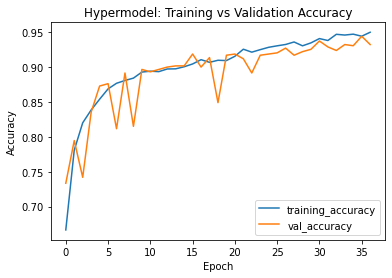

In [70]:
plt.plot(history_bm.history['accuracy'], label='training_accuracy')
plt.plot(history_bm.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
 #plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Hypermodel: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Hypermodel: Training vs Validation Loss')

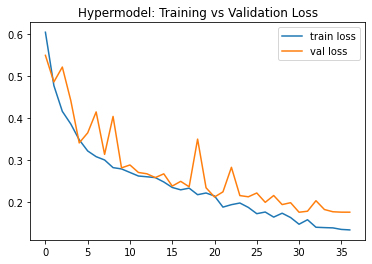

In [71]:
plt.plot(history_bm.history['loss'], label='train loss')
plt.plot(history_bm.history['val_loss'], label='val loss')
plt.legend()
plt.title("Hypermodel: Training vs Validation Loss")

In [72]:
test_loss, test_acc = best_model.evaluate(test_generator)
print("Test Accuracy: "+str(test_acc))
print("Test Loss: "+str(test_loss))

19/19 [==============================] - 6s 313ms/step - loss: 0.2306 - accuracy: 0.9007
Test Accuracy: 0.9006733894348145
Test Loss: 0.23058761656284332


# 5-fold cross-validation with zero-one loss

In [94]:
# Define the zero-one loss function for estimating the cross-validation risk
def zero_one_loss(y_true, y_pred):
    """Compute the zero-one loss."""
    assert len(y_true) == len(y_pred)
    return sum(y_true != y_pred) / len(y_true)

In [151]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

In [152]:
# 5-fold cross validation to the 5th model (sub-optimal model)
acc_per_fold_sub = [] 
loss_per_fold_sub = []
zero_one_loss_per_fold_sub = []

fold_no = 1
for train, test in kfold.split(inputs, targets):
    model_sub = model5()
    # Train the model
    print(f'Training fold {fold_no}...')
    history_sub = model_sub.fit(inputs[train], targets[train],
                        batch_size=32,
                        epochs=25,
                        verbose=1,
                        validation_split=0.2,
                        callbacks=get_callbacks(6))
    
    # Predict the classes on the test fold
    y_pred = model_sub.predict(inputs[test], batch_size=32)
    # Ensure predictions are in the same format as labels. If model outputs probabilities for binary classification:
    y_pred = (y_pred > 0.5).astype('int32').flatten()
    
    # Evalutate the model
    scores = model_sub.evaluate(inputs[test], targets[test], verbose=1)
    print(f'Score for fold {fold_no}: Loss = {scores[0]}, Accuracy = {scores[1]*100}%')
    # Compute the zero-one loss
    zero_one_loss_value = zero_one_loss(targets[test], y_pred)
    print(f'Score for fold {fold_no}: Zero-One Loss = {zero_one_loss_value}')
    
    zero_one_loss_per_fold_sub.append(zero_one_loss_value)
    acc_per_fold_sub.append(scores[1])
    loss_per_fold_sub.append(scores[0])
    
    fold_no += 1

print('------------------------------------------------------------------------')
print('Average and standard deviation for all folds')
print(f'> Accuracy: {np.mean(acc_per_fold_sub)} (+- {np.std(acc_per_fold_sub)})')
print(f'> Loss: {np.mean(loss_per_fold_sub)}')
print(f'> Zero-One Loss: {np.mean(zero_one_loss_per_fold_sub)} (+- {np.std(zero_one_loss_per_fold_sub)})')
print('------------------------------------------------------------------------')

Training fold 1...
Epoch 1/25
107/107 [==============================] - 34s 290ms/step - loss: 0.6716 - accuracy: 0.5898 - val_loss: 0.7134 - val_accuracy: 0.5615
Epoch 2/25
107/107 [==============================] - 29s 272ms/step - loss: 0.5569 - accuracy: 0.7515 - val_loss: 0.4368 - val_accuracy: 0.8089
Epoch 3/25
107/107 [==============================] - 32s 298ms/step - loss: 0.5007 - accuracy: 0.7835 - val_loss: 0.4326 - val_accuracy: 0.8347
Epoch 4/25
107/107 [==============================] - 30s 281ms/step - loss: 0.4719 - accuracy: 0.7958 - val_loss: 0.3877 - val_accuracy: 0.8605
Epoch 5/25
107/107 [==============================] - 30s 278ms/step - loss: 0.4443 - accuracy: 0.8154 - val_loss: 0.3777 - val_accuracy: 0.8710
Epoch 6/25
107/107 [==============================] - 30s 279ms/step - loss: 0.4315 - accuracy: 0.8201 - val_loss: 0.4255 - val_accuracy: 0.7995
Epoch 7/25
107/107 [==============================] - 30s 281ms/step - loss: 0.4193 - accuracy: 0.8257 - val_lo

In [153]:
# 5-fold cross validation to the 'hypermodel': best model available
acc_per_fold_hp = [] 
loss_per_fold_hp = []
zero_one_loss_per_fold_hp = []

fold_no = 1
for train, test in kfold.split(inputs, targets):
    model_hp = tuner.hypermodel.build(best_hps)
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    print(f'Training fold {fold_no}...')
    history = model_hp.fit(inputs[train], targets[train],
                        batch_size=32,
                        epochs=25,
                        verbose=1, 
                        validation_split=0.2,
                        callbacks=get_callbacks(6))
    
    # Predict the classes on the test fold
    y_pred = model_hp.predict(inputs[test], batch_size=32)
    # Ensure predictions are in the same format as labels. If model outputs probabilities for binary classification:
    y_pred = (y_pred > 0.5).astype('int32').flatten()
    
    # Evalutate the model
    scores = model_hp.evaluate(inputs[test], targets[test], verbose=1)
    print(f'Score for fold {fold_no}: Loss = {scores[0]}, Accuracy = {scores[1]*100}%')
    # Compute the zero-one loss
    zero_one_loss_value = zero_one_loss(targets[test], y_pred)
    print(f'Score for fold {fold_no}: Zero-One Loss = {zero_one_loss_value}')
    
    zero_one_loss_per_fold_hp.append(zero_one_loss_value)
    acc_per_fold_hp.append(scores[1])
    loss_per_fold_hp.append(scores[0])

    fold_no += 1

print('------------------------------------------------------------------------')
print('Average and standard deviation for all folds')
print(f'> Accuracy: {np.mean(acc_per_fold_hp)} (+- {np.std(acc_per_fold_hp)})')
print(f'> Loss: {np.mean(loss_per_fold_hp)}')
print(f'> Zero-One Loss: {np.mean(zero_one_loss_per_fold_hp)} (+- {np.std(zero_one_loss_per_fold_hp)})')
print('------------------------------------------------------------------------')

Training fold 1...
Epoch 1/25
107/107 [==============================] - 33s 304ms/step - loss: 0.6604 - accuracy: 0.5866 - val_loss: 0.7098 - val_accuracy: 0.5416
Epoch 2/25
107/107 [==============================] - 32s 303ms/step - loss: 0.5055 - accuracy: 0.7664 - val_loss: 0.5375 - val_accuracy: 0.7784
Epoch 3/25
107/107 [==============================] - 34s 320ms/step - loss: 0.4350 - accuracy: 0.8128 - val_loss: 0.4956 - val_accuracy: 0.7972
Epoch 4/25
107/107 [==============================] - 35s 323ms/step - loss: 0.4056 - accuracy: 0.8298 - val_loss: 0.5538 - val_accuracy: 0.7374
Epoch 5/25
107/107 [==============================] - 32s 297ms/step - loss: 0.3664 - accuracy: 0.8492 - val_loss: 0.4292 - val_accuracy: 0.8406
Epoch 6/25
107/107 [==============================] - 32s 297ms/step - loss: 0.3272 - accuracy: 0.8609 - val_loss: 0.4324 - val_accuracy: 0.8370
Epoch 7/25
107/107 [==============================] - 31s 286ms/step - loss: 0.3210 - accuracy: 0.8750 - val_lo

In [156]:
histories =  []
for train, test in kfold.split(inputs, targets):
    histories.append(history)

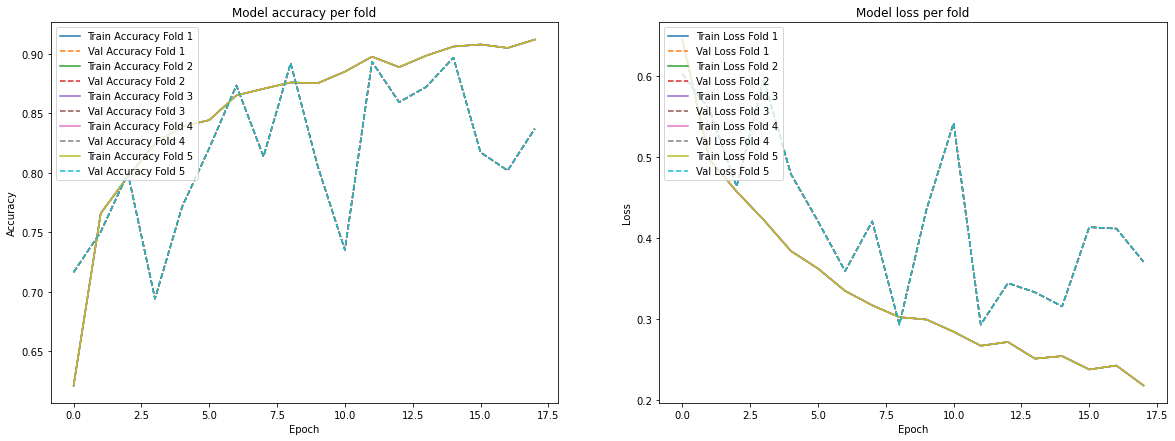

In [158]:
# Now, plot the learning curves
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot accuracy
for i, history in enumerate(histories):
    ax[0].plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    ax[0].plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}', linestyle="--")
ax[0].set_title('Model accuracy per fold')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

# Plot loss
for i, history in enumerate(histories):
    ax[1].plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    ax[1].plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}', linestyle="--")
ax[1].set_title('Model loss per fold')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper left')

plt.show()